# One Weird Trick To Detecting and Handling Outliers
- The best way to detect anomalies is to know your domain
- While there are rules and heuristics for detecting outliers
- One analysts's noise is another analyst's signal (depending on what they're looking for)
- What determines if a data point is an outlier is a function of who determines if that data point is anomalous and why.

## The following example detects/handles outliers without a rule, only domain knowledge

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
url = "https://gist.githubusercontent.com/ryanorsinger/19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4782f96cad6d1d62a8bdbac54c7/lemonade.csv"

df = pd.read_csv(url)
# df = pd.read_csv("lemonade.csv")
df.head()

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


## Set the Date column to be a datetime type and the index

In [6]:
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")

In [7]:
df["month"] = df.index.month_name()

In [8]:
df.head()

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-01-01,Sunday,27.0,2.00,15,0.5,10,January
2017-01-02,Monday,28.9,1.33,15,0.5,13,January
2017-01-03,Tuesday,34.5,1.33,27,0.5,15,January
2017-01-04,Wednesday,44.1,1.05,28,0.5,17,January
2017-01-05,Thursday,42.4,1.00,33,0.5,18,January


## Get to know the data before using any rules for keeping/removing outliers
1. Visualize the continuous variables 
2. Like with vizualizing Anscombe's Quartet
    - We're looking for patterns and a picture is worth 1000 words.
    - By plotting values, we see more of the picture than `.describe` can show on its own

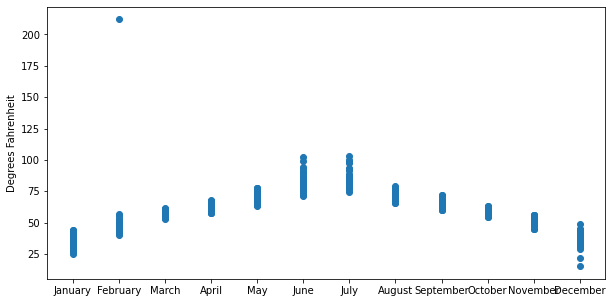

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(df.month, df.Temperature)
plt.ylabel("Degrees Fahrenheit")
plt.show()

In [10]:
# Let's look at the highest temperature days
# Looks like something is going on with that temperature above 200...
df[df.Temperature > 100]

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-02-11,Saturday,212.0,0.91,35,0.5,21,February
2017-06-26,Monday,102.6,0.47,60,0.5,42,June
2017-07-01,Saturday,102.9,0.47,59,0.5,143,July


In [8]:
# Let's take a look at the days nearby.
df.loc["2017-02-09":"2017-02-13"]

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-02-09,Thursday,42.7,1.00,39,0.5,19,February
2017-02-10,Friday,50.0,0.91,40,0.5,20,February
2017-02-11,Saturday,212.0,0.91,35,0.5,21,February
2017-02-12,Sunday,55.6,0.83,41,0.5,22,February
2017-02-13,Monday,46.4,1.11,34,0.5,18,February


### What's the story with Feb 11th? 
- This outlier is so funky/unreal, it might as well be a null
- If we drop the entire row, then we have an entire row of nulls
- We could replace this day's temperature with the day before, the day after, or average the week. 
- I'd rather replace this value with a temperature from February than the average of the year.

In [11]:
# Let's assign the temperature for this day to be the same temperature as yesterday
df.loc[df.Temperature == 212, "Temperature"] = df.loc["2017-02-10"].Temperature

In [12]:
# Ensure that the outlier was replaced with the previous day's temperature
df.loc["2017-02-09":"2017-02-11"]

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-02-09,Thursday,42.7,1.00,39,0.5,19,February
2017-02-10,Friday,50.0,0.91,40,0.5,20,February
2017-02-11,Saturday,50.0,0.91,35,0.5,21,February


### Let's check for anomalies in the Flyers column
- Easiest way to check is to visualize the value

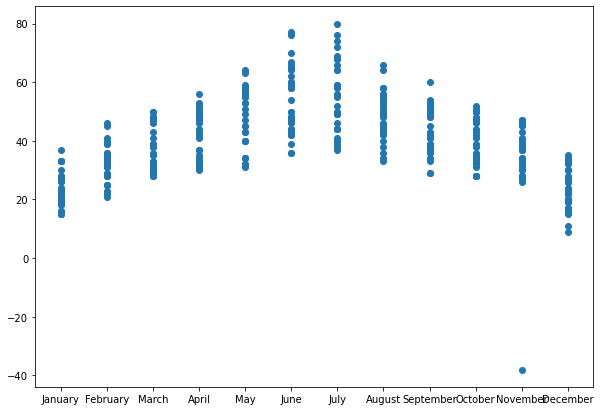

In [13]:
plt.figure(figsize=(10, 7))
plt.scatter(df.month, df.Flyers)

In [14]:
# What is the index of that negative Flyer value?
df.Flyers.idxmin()

Timestamp('2017-11-21 00:00:00')

In [15]:
# Negative flyers don't make sense. Let's look at what's going on near that observation
df.loc["2017-11-19":"2017-11-23"]

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-11-19,Sunday,55.9,0.87,34,0.5,23,November
2017-11-20,Monday,55.6,0.87,41,0.5,22,November
2017-11-21,Tuesday,47.0,0.95,-38,0.5,20,November
2017-11-22,Wednesday,48.7,1.00,40,0.5,19,November
2017-11-23,Thursday,51.9,0.87,47,0.5,23,November


In [16]:
# It looks like this negative flyer value is a simple typo
# And since the business isn't giving out a negative amount of promotional flyers, then we can take the absolute value
df.Flyers = df.Flyers.abs()
df.loc["2017-11-21"].Flyers

38

### Let's look at the rainfall data
- Looks good, no funky anomalies
- It seems to always be raining at this location, but other than that, things look good.

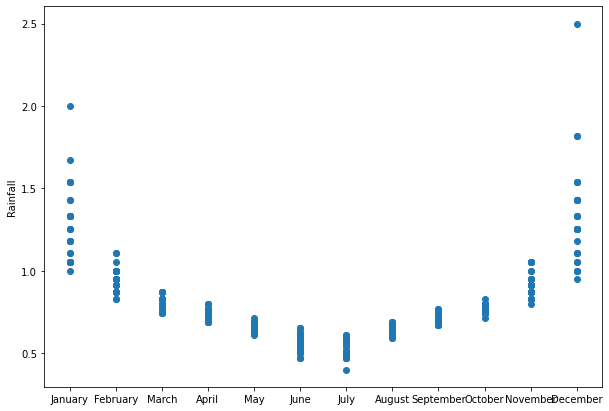

In [17]:
plt.figure(figsize=(10,7))
plt.ylabel("Rainfall")
plt.scatter(df.month, df.Rainfall)
plt.show()

### Let's Check Sales Data for Anomalies

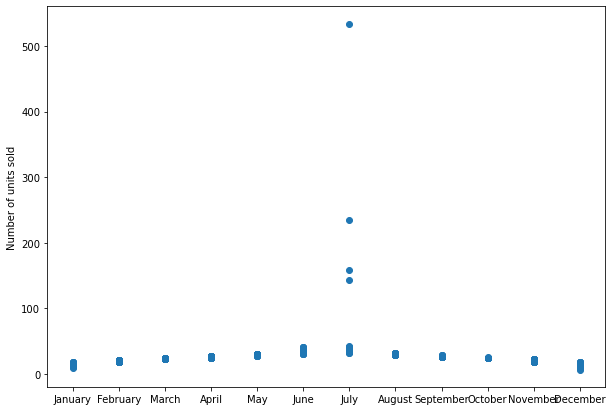

In [18]:
plt.figure(figsize=(10, 7))
plt.scatter(df.month, df.Sales)
plt.ylabel("Number of units sold")
plt.show()

In [19]:
# Let's look at the rows with high sales a little more closely
df[df.Sales > 50]

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-07-01,Saturday,102.9,0.47,59,0.5,143,July
2017-07-02,Sunday,93.4,0.51,68,0.5,158,July
2017-07-03,Monday,81.5,0.54,68,0.5,235,July
2017-07-04,Tuesday,84.2,0.59,49,0.5,534,July


### What other information do these rows tell us?
- The other continuous data doesn't tell us much
- What about the dates? 
- **hint** What is special about the day with the highest sales?

### Should we keep the Sales outliers?
- If we're running this business in Texas and we're looking to franchise in New Mexico, should we keep the Sales outliers as part of our sales predictions?
- If we're running this biz in Texas and looking to franchise in New Zealand, should we keep the ouliers or ignore them in the predicted sales analysis?

In [23]:
def get_lower_and_upper_bounds(col, mult=1.5):
    '''
    positional arguments:
    col: a pandas Series
    keyword arguments:
    mult: default 1.5, the magnutude specified for the IQR rule
    
    returns:
    lower_bound, upper_bound: two float values representing the fence values requested
    '''
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - mult * iqr
    upper_bound = q3 + mult * iqr
    return lower_bound,upper_bound

In [54]:
# at a multiplier of 1.5:
outliers = {}
for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        lower_bound, upper_bound = get_lower_and_upper_bounds(df[col])
        print(f' Lower bound for {col} : {lower_bound}\n Upper bound for {col}: {upper_bound}\n')
        print('-----------------')
        outliers[col] = {}
        outliers[col]['bounds'] = {'upper': upper_bound, 'lower': lower_bound}
        outliers[col]['df'] = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
    else:
        pass

 Lower bound for Temperature : 17.30000000000001
 Upper bound for Temperature: 103.69999999999999

-----------------
 Lower bound for Rainfall : 0.26
 Upper bound for Rainfall: 1.3

-----------------
 Lower bound for Flyers : 4.0
 Upper bound for Flyers: 76.0

-----------------
 Lower bound for Price : 0.5
 Upper bound for Price: 0.5

-----------------
 Lower bound for Sales : 5.0
 Upper bound for Sales: 45.0

-----------------


In [57]:
outliers.keys()

dict_keys(['Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales'])

In [58]:
outliers['Temperature']['df']

,Day,Temperature,Rainfall,Flyers,Price,Sales,month
Date,,,,,,,
2017-12-31,Sunday,15.1,2.5,9,0.5,7,December


In [62]:
outliers['Rainfall']

{'bounds': {'upper': 1.3, 'lower': 0.26},
 'df':                   Day  Temperature  Rainfall  Flyers  Price  Sales     month
 Date                                                                        
 2017-01-01     Sunday         27.0      2.00      15    0.5     10   January
 2017-01-02     Monday         28.9      1.33      15    0.5     13   January
 2017-01-03    Tuesday         34.5      1.33      27    0.5     15   January
 2017-01-06     Friday         25.3      1.54      23    0.5     11   January
 2017-01-07   Saturday         32.9      1.54      19    0.5     13   January
 2017-01-11  Wednesday         32.6      1.54      23    0.5     12   January
 2017-01-12   Thursday         38.2      1.33      16    0.5     14   January
 2017-01-13     Friday         37.5      1.33      19    0.5     15   January
 2017-01-16     Monday         30.6      1.67      24    0.5     12   January
 2017-01-17    Tuesday         32.2      1.43      26    0.5     14   January
 2017-01-20     